In [19]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, MixedDataLoader

####

from pathlib import Path
from typing import Tuple, Dict, Any, Callable

import jax
import jax.lax
import jax.numpy as jnp
from jax.random import PRNGKey
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506131953_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506131953_0


In [34]:
class ConditionalRBM(nn.Module):
    num_visible: int
    num_hidden: int
    conditioner_width: int = 64
    k: int = 1
    T: float = 1.0

    def setup(self):
        # we use frozen RBM parameters
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W = self.variable("rbm", "W", zeros, (self.num_visible, self.num_hidden))
        self.b = self.variable("rbm", "b", zeros, (self.num_visible,))   # global init
        self.c = self.variable("rbm", "c", zeros, (self.num_hidden,))    # global init

    @nn.compact
    def conditioner(self, condition: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        # takes in batch of conditions lenght D, in our case one-hot measurement encodings (B, N, 4)
        x = nn.Dense(self.conditioner_width)(condition)     # (B, N, D)
        x = nn.tanh(x)
        x = x.reshape(x.shape[0], -1)                        # (B, N * D)
        x = nn.Dense(2 * (self.num_visible + self.num_hidden))(x)
        split_indices = [self.num_visible, 2 * self.num_visible, 2 * self.num_visible + self.num_hidden]
        gamma_b, beta_b, gamma_c, beta_c = jnp.split(x, split_indices, axis=-1)
        return gamma_b, beta_b, gamma_c, beta_c              # correction parameters have batch dim again (B, N/H)

    @nn.nowrap
    def forward_conditioner(self, basis_bits: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        basis_one_hot = self.encode_one_hot(basis_bits)           # (B, N, 4)
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(basis_one_hot)
        return gamma_b, beta_b, gamma_c, beta_c


    @staticmethod
    def encode_one_hot(basis_bits: jnp.ndarray) -> jnp.ndarray:
        basis_int = basis_bits[:, :, 0] * 2 + basis_bits[:, :, 1] # split high and low bits
        return jax.nn.one_hot(basis_int, 4, dtype=jnp.float32)

    @staticmethod
    def prepare_batch(batch: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        # split off actual measurements and from basis bits and encode the basis bits as one-hot vectors
        measurements = batch[:, :, 0].astype(jnp.float32)       # (B, N)
        basis_high_bits = batch[:, :, 1].astype(jnp.int32)      # (B, N, 1)
        basis_low_bits = batch[:, :, 2].astype(jnp.int32)

        basis_int = basis_high_bits * 2 + basis_low_bits        # (B, N, 1)
        basis_one_hot = jax.nn.one_hot(basis_int, 4, dtype=jnp.float32)

        return measurements, basis_one_hot

    @staticmethod
    def _free_energy(v, W, b, c) -> jnp.ndarray:
        return -(v @ b) - jnp.sum(jax.nn.softplus(v @ W + c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        measurement = batch[:, :, 0].astype(jnp.float32)  # (B, N)
        basis_bits = batch[:, :, 1:].astype(jnp.int32)  # (B, N, 2)
        basis_one_hot = self.encode_one_hot(basis_bits)

        # each measurement sample gets its own FiLM modulation
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(basis_one_hot)
        b_mod = (1 + gamma_b) * self.b.value + beta_b  # (B, N)
        c_mod = (1 + gamma_c) * self.c.value + beta_c  # (B, H)

        # we run the gibbs chain starting from noise steering it towards a measurement outcome in agiven basis
        key, key_init = jax.random.split(aux_vars["key"])
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=measurement.shape).astype(jnp.float32)  # (B, N)
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W.value, b_mod, c_mod, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain) # chain is non-differentiable

        # compute per-sample free energies
        free_energy_data  = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(measurement, self.W.value, b_mod, c_mod)
        free_energy_model = jax.vmap(self._free_energy, in_axes=(0, None, 0, 0))(gibbs_chain, self.W.value, b_mod, c_mod)

        # pair up the free energies and compute the gap
        free_energy_delta = free_energy_data - free_energy_model  # shape (B,)

        # statistics
        free_energy_mean = jnp.mean(free_energy_delta)
        free_energy_std  = jnp.std(free_energy_delta)

        # penalize drift from original biases (we need to add a dummy batch dim for broadcasting)
        l2_regularization = (jnp.sum((self.b.value[None, :] - b_mod) ** 2) + jnp.sum((self.c.value[None, :] - c_mod) ** 2))

        loss = free_energy_mean + aux_vars["l2_strength"] * l2_regularization

        aux_vars_out = {
            "key": key,
            "free_energy_mean": free_energy_mean,
            "free_energy_std": free_energy_std,
        }

        return loss, aux_vars_out

    @nn.nowrap
    def generate(self, basis_bits: jnp.ndarray, T_schedule: jnp.ndarray, key: PRNGKey) -> Tuple[jnp.ndarray, PRNGKey]:
        basis_one_hot = self.encode_one_hot(basis_bits)

        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(basis_one_hot)
        b_mod = (1 + gamma_b) * self.b.value + beta_b
        c_mod = (1 + gamma_c) * self.c.value + beta_c

        batch_size, num_visible, _ = basis_bits.shape
        key, key_init = jax.random.split(key, 2)

        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=(batch_size, num_visible)).astype(jnp.float32)  # (B, N)
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W.value, b_mod, c_mod, T_schedule[i])
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key))

        return gibbs_chain, key

In [35]:
@jax.jit
def train_step(
        state: TrainState,
        batch: jnp.ndarray,
        rbm_vars: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params, 'rbm': rbm_vars}, batch, aux_vars)

    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, aux_vars


def train(
        state: TrainState,
        rbm_vars: Dict[str, jnp.ndarray],
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float]) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    gibbs_chain = None

    for epoch in range(num_epochs):
        tot_loss = 0.0

        for batch in loader:
            measurements = batch[:, :, 0].astype(jnp.float32)

            if gibbs_chain is None:
                #gibbs_chain = measurements  # initial random init could be better
                gibbs_chain = jax.random.bernoulli(key, 0.5, shape=measurements.shape).astype(jnp.float32)  # (B, N)


            key, subkey = jax.random.split(key)
            aux_vars = {
                "key": subkey,
                "l2_strength": l2_strength,
            }

            state, loss, aux_vars = train_step(state, batch, rbm_vars, aux_vars)
            key = aux_vars["key"]
            free_energy_mean = aux_vars["free_energy_mean"]
            free_energy_std = aux_vars["free_energy_std"]

            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        lr = lr_schedule_fn(state.step)

        metrics[epoch] = dict(
            loss=avg_loss,
            free_energy_mean=free_energy_mean,
            free_energy_var=free_energy_std,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Free En. Mean: {free_energy_mean:.4f} │ "
              f"Free En. STD: {free_energy_std:.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [36]:
# load the RBM parameters and parse the data
rbm_params = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)
rbm_vars = {"W": rbm_params["W"], "b": rbm_params["b"], "c": rbm_params["c"]}

file_path = Path("data/w_aug_8MIXED_30000.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 30000/30000 [00:01<00:00, 24216.42it/s]


In [37]:
batch_size      = 2048
num_visible     = 8
num_hidden      = 16
conditioner_width = 64
num_epochs      = 500
k_steps         = 1                        # we dont want to mix to much to give the conditioner large gradients
init_lr         = 1e-2                      # lucky guess. a larger learning rate is actually better as it seems
final_lr        = init_lr * 0.1
l2_strength     = 0

key = jax.random.PRNGKey(0)

key, key_params, key_dummy = jax.random.split(key, 3)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, conditioner_width=conditioner_width, k=k_steps)

batch_dummy = jnp.zeros((batch_size, num_visible, 3), dtype=jnp.float32)
aux_vars_dummy = { "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optim = optax.adam(lr_schedule_fn)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optim)

state, metrics = train(state, rbm_vars, loader, num_epochs, key, l2_strength, lr_schedule_fn)

Epoch 1/500 │ Loss: +3.1769 │ Free En. Mean: 1.5931 │ Free En. STD: 4.3290 │ Learning Rate: 0.00880
Epoch 2/500 │ Loss: +1.5045 │ Free En. Mean: 1.4699 │ Free En. STD: 4.5264 │ Learning Rate: 0.00879
Epoch 3/500 │ Loss: +1.3728 │ Free En. Mean: 1.2441 │ Free En. STD: 3.8800 │ Learning Rate: 0.00878
Epoch 4/500 │ Loss: +1.3769 │ Free En. Mean: 1.4982 │ Free En. STD: 3.8498 │ Learning Rate: 0.00877
Epoch 5/500 │ Loss: +1.3808 │ Free En. Mean: 1.3983 │ Free En. STD: 3.8158 │ Learning Rate: 0.00876
Epoch 6/500 │ Loss: +1.4468 │ Free En. Mean: 1.5744 │ Free En. STD: 3.6961 │ Learning Rate: 0.00876
Epoch 7/500 │ Loss: +1.5210 │ Free En. Mean: 1.6617 │ Free En. STD: 3.7040 │ Learning Rate: 0.00875
Epoch 8/500 │ Loss: +1.4680 │ Free En. Mean: 1.3128 │ Free En. STD: 3.7913 │ Learning Rate: 0.00874
Epoch 9/500 │ Loss: +1.4065 │ Free En. Mean: 1.5815 │ Free En. STD: 3.8977 │ Learning Rate: 0.00873
Epoch 10/500 │ Loss: +1.4259 │ Free En. Mean: 1.4462 │ Free En. STD: 3.8165 │ Learning Rate: 0.00872

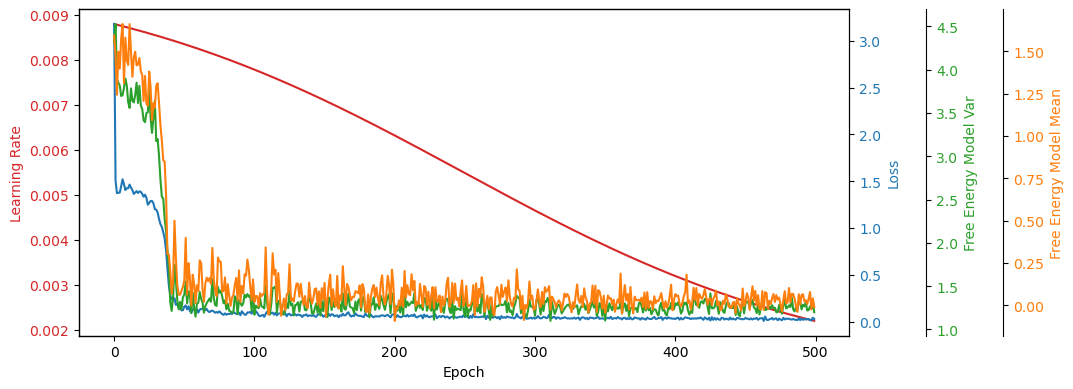

In [38]:
epochs = list(metrics.keys())

loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [47]:
# a quick test is to test whether the conditioner can condition on the Z basis

T_high = 2.0
T_low = 0.01
sampling_steps = 100
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

# construct a batch of basis bits in Z direction
num_samples = 10
basis_bits = jnp.ones((num_samples, num_visible, 2), dtype=jnp.float32)

all_vars = { "params": state.params, "rbm": rbm_vars }

key_sample = jax.random.PRNGKey(42)
samples, key_sample = model.apply(all_vars, basis_bits, sigmoid_schedule, key_sample, method=ConditionalRBM.generate)

sampled_freq = samples.mean(axis=0)
sampled_freq

Array([0.6, 0.2, 0.5, 0.3, 0.2, 0.5, 0.4, 0.3], dtype=float32)

In [48]:
samples

Array([[1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 0.],
       [0., 0., 1., 1., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0., 0.]], dtype=float32)

In [63]:
# we would hope the conditioner to produce no conditioning in the Z basis

gamma_b, beta_b, gamma_c, beta_c = model.apply(
    all_vars,
    basis_bits[0:1],  # take the first sample's basis bits
    method=ConditionalRBM.forward_conditioner
)

gamma_b